<h1><center>CS6140 Project - COVID-19 Tweet Scanner</center></h1>

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import warnings 
warnings.filterwarnings("ignore")

In [2]:
path = 'COVID19 Tweets.csv'
df = pd.read_csv(path,encoding = 'latin')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


#### This shows that there are null values in the location column.

## Exploratory Data Analysis

In [4]:
#41157 rows and 6 columns in our dataset
df.shape

(41157, 6)

In [5]:
# Names Of columns in our dataset
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [6]:
# TweetAt - March and April 2020
df.TweetAt.value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

In [7]:
# There are 12220 unique locations from where the tweets came.
df['Location'].value_counts()

London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: Location, Length: 12220, dtype: int64

In [8]:
# There are 5 unique label values (sentiment types) in our dataset
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

### Unique Values In Each Feature Coulmn

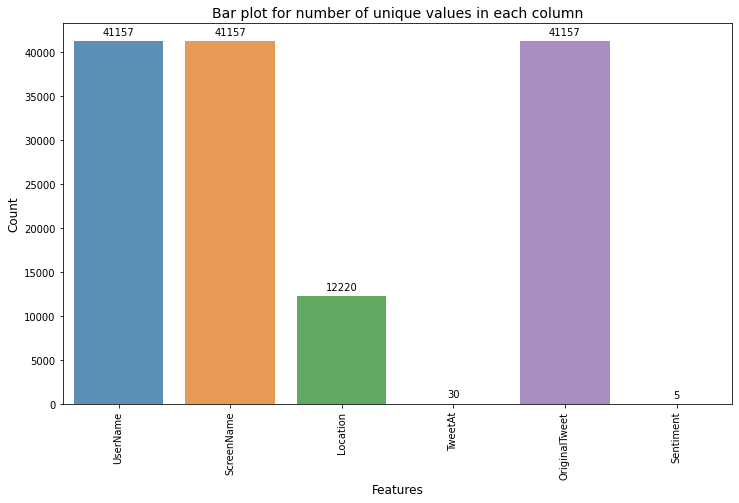

In [9]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1,figsize=(12,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column', size=14)
plt.ylabel('Count', size=12)
plt.xlabel('Features', size=12)
plt.xticks(rotation=90)
plt.show()

### Plot of frequent Locations Of Tweet

In [10]:
# pip install plotly

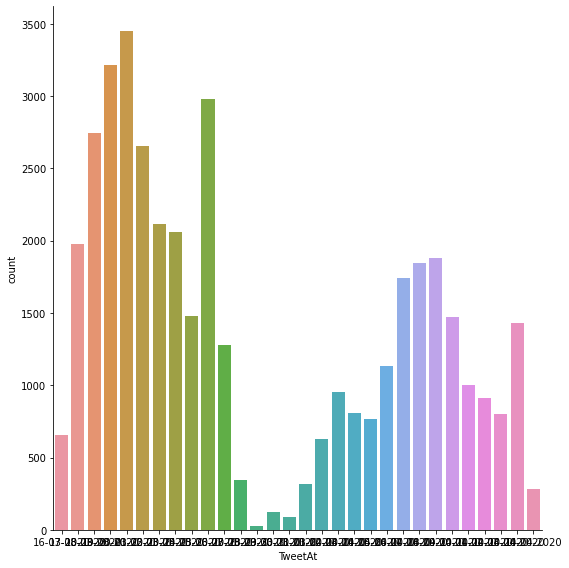

In [11]:
import plotly.graph_objects as go
loc_analysis = pd.DataFrame(df['Location'].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={'Location':'count'})

data = {
   "values": loc_analysis['count'][:15],
   "labels": loc_analysis.index[:15],
   "domain": {"column": 0},
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Ratio of Tweet Location</b>", legend=dict(x=0.1, y=1.1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()
sns.catplot("TweetAt", data=df, kind="count", height=8)

### Top 10 locations of tweet

In [12]:
Top_Location_Of_tweet= df['Location'].value_counts().head(10)

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

# Top_Location_Of_tweet.head(10)
Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_Of_tweet_df

,Location,Location_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


[Text(0, 0, 'London'),
 Text(1, 0, 'United States'),
 Text(2, 0, 'London, England'),
 Text(3, 0, 'New York, NY'),
 Text(4, 0, 'Washington, DC'),
 Text(5, 0, 'United Kingdom'),
 Text(6, 0, 'Los Angeles, CA'),
 Text(7, 0, 'India'),
 Text(8, 0, 'UK'),
 Text(9, 0, 'Australia')]

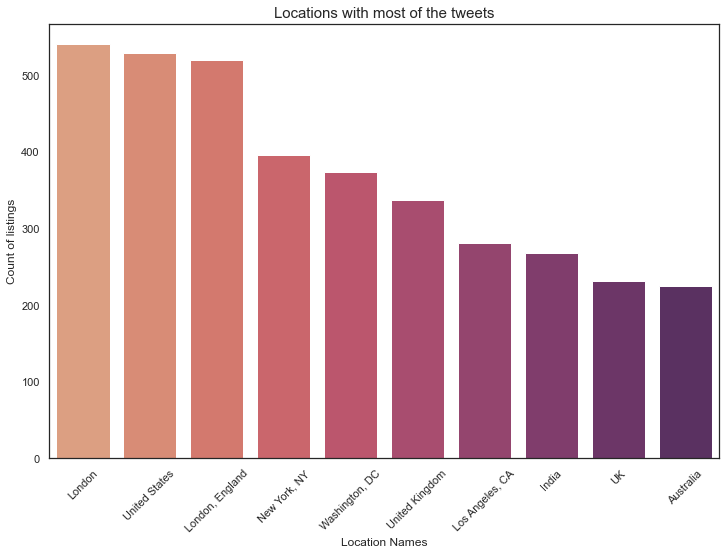

In [13]:
viz_1=sns.barplot(x="Location", y="Location_Count", data=Top_Location_Of_tweet_df,
                 palette='flare')
viz_1.set_title('Locations with most of the tweets', size=15)
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Location Names')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

### Plot of Sentiment Count

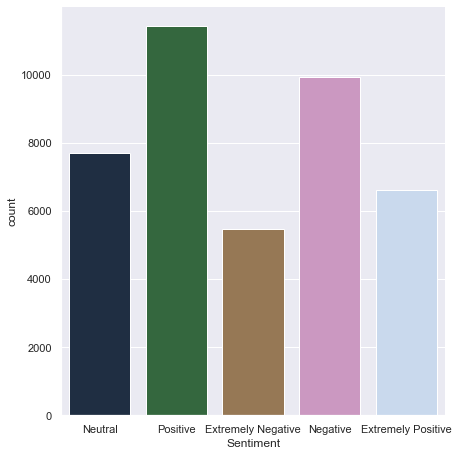

In [14]:
sns.set(font_scale=1)
sns.catplot("Sentiment", data=df, kind="count", height=6.5, palette='cubehelix')

In [15]:
df.TweetAt.value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

### WordCloud - Interactive Visualization

WordClouds are visual representations of words that give greater prominence to words that appear more frequentlyand also helps us to generate and visualize most common words in the entire dataset and also, most common words in the dataset for negative and positive tweets, respectively
<br></br>
In order to get an idea of what are the words that contribute the most to different labels, we developed a function to generate word clouds. The function takes in a parameter label which will output the word cloud for that sentiment in our dataset.

In [16]:
def wordCloud(sentiment):
    """
    Visualize the most common words contributing to the label.
    """
    normal_words = []
    normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == sentiment]])
    wordcloud = WordCloud(width=800, height=500, random_state=21, 
                          max_font_size=120, background_color='white').generate(normal_words)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="gist_earth"), interpolation="bilinear")
    plt.title(f"Most common words assosiated with {sentiment} tweet", size=15)
    plt.axis('off')
    plt.show()

In [17]:
# Interactive wordcloud visualization
# Enter the class label name from the list: Extremely Positive, Positive, Neutral, Negative, Extremely Negative
sentiment_list = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']
sentiment = input(
    'Choose a class to visualize the most common words contributing to the sentiment: ')
if sentiment.capitalize() in sentiment_list:
    wordCloud(sentiment.capitalize())
else:
    print("Sorry, class label not present in dataset. Please choose from the list provided above.")

Sorry, class label not present in dataset. Please choose from the list provided above.


## Data Preprocessing

### Removal of @username from the tweets

In [18]:
#function for removing @username
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

# create new column of tweet with removed @username
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [19]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"


### Removal of URL from the tweets

In [20]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [21]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"


### Removal of punctuations, numbers and other special characters

In [22]:
# removing special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [23]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID outbreak


### Removal of stop words from the tweets

In [24]:
# removing stop words based on length
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [25]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...


### Tokenization

In [26]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())
# print(tokenized_tweet)

### Stemming

In [27]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# applying stemmer to tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [28]:
# combining tokenized words into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
# change df['Tweet'] to tokenized_tweet
df['Tweet']  = tokenized_tweet

In [29]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak


### Extracting Tweet and User Sentiment

In [30]:
new_df = df[['Tweet','Sentiment']]

In [31]:
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [32]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [35]:
new_df.shape

(41157, 2)

In [36]:
new_df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [37]:
new_df.loc[new_df["Sentiment"] == "Extremely Negative", "Sentiment"] = "Negative"
new_df.loc[new_df["Sentiment"] == "Extremely Positive", "Sentiment"] = "Positive"
new_df['Sentiment'].replace(['Negative','Neutral','Positive'],
                        [0, 1, 2], inplace=True)
new_df.head(7)

,Tweet,Sentiment
0,,1
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,2
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,2
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,2
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,0
5,news the region first confirm covid case came out sullivan counti last week peopl flock area store purchas clean suppli hand sanit food toilet paper and other good report,2
6,cashier groceri store wa share hi insight #covid prove hi credibl comment civic class know what talk about,2


## Modeling Methodology - Machine Learning Approach

In [38]:
# Splitting the dataset into train and test data
train, test = train_test_split(new_df, test_size = 0.2, random_state=42, stratify = new_df.Sentiment.values) 
print("train shape : ", train.shape)
print("test shape : ", test.shape)

train shape :  (32925, 2)
test shape :  (8232, 2)


### Implementing Naive Bayes from Scratch

In [39]:
class NaiveBayes:
  def __init__(self):
    """
    Initializing the class variables
    """
    self.vocab_size = 0
    self.vocab_dict = dict()
    self.label_dict = dict()
    self.label_count_dict = dict()
    self.label_prob_dict = dict()

  def train(self, examples):
    """
    Trains the classifier based on the given examples
    Parameters:
      examples - a list of tuples of strings formatted
    Return: None
    """
    for example in examples:
      label = example[1]
      if(label not in self.label_dict):
        self.label_dict[label] = dict()
      label_word_dict = self.label_dict[label]
      words = example[0].split(" ")
      label_count = 0
      for word in words:
        if(word not in label_word_dict):
          label_word_dict[word] = 1
        else:
          count = label_word_dict[word]
          count+=1
          label_word_dict[word] = count

        if(word not in self.vocab_dict):
          self.vocab_dict[word] = 1
        else:
          count = self.vocab_dict[word]
          count+=1
          self.vocab_dict[word] = count
        label_count += 1
      self.label_dict[label] = label_word_dict

      if(label not in self.label_prob_dict):
        self.label_prob_dict[label] = 1
      else:
        count = self.label_prob_dict[label]
        count+=1
        self.label_prob_dict[label] = count

      if(label not in self.label_count_dict):
        self.label_count_dict[label] = label_count
      else:
        count = self.label_count_dict[label]
        count+=label_count
        self.label_count_dict[label] = count
    
    self.label_prob_dict = self.get_class_probability(self.label_prob_dict)
    self.vocab_size = len(self.vocab_dict)
  
  def get_class_probability(self, label_prob_dict):
    """
    Gets the probability of each class in the dataset
    Parameters:
      label_prob_dict - A dictionary containing the counts of each label
    Return: dict of class probablity
    """
    total_class_count = 0
    for key in label_prob_dict.keys():
      total_class_count += label_prob_dict[key]
    for key in label_prob_dict.keys():
      label_prob_dict[key] = label_prob_dict[key] / total_class_count
    return label_prob_dict

  def score(self, data):
    """
    Score a given piece of text
    Parameters:
      data - String containing the tweet
    Return: dict of class: score mappings
    """
    class_score_dict = dict()
    features = self.featurize(data)
    for key in self.label_dict.keys():
      words = data.split(" ")
      prob = 0
      for word in words:
          score = self.get_word_probability(key,word,features)
          prob = prob+ np.log(score)
      prob = prob + np.log(self.label_prob_dict[key])
      prob = np.e**prob
      class_score_dict[key] = prob
    return class_score_dict      

  def get_word_probability(self,label,word,features):
    """
    Gets the probability of the word given label
    Parameters:
      label - A string indicating the label
      word - The word for which the probability has to be found
      features - A list of tuples which we get from featurize
    Returns - float: A number between 0 and 1
    """
    for i,j in features:
      if(word == i and j == False):
        return 1
    if(word in self.label_dict[label]):
      return float((self.label_dict[label][word]+1) / (self.label_count_dict[label]+ self.vocab_size))
    if(word not in self.label_dict[label] and word in self.vocab_dict):
      return float(1 / (self.label_count_dict[label]+ self.vocab_size))

  def classify(self, data):
    """
    Label a given piece of text
    Parameters:
      data - str containing the tweet
    Return: string class label
    """
    prob_dict = self.score(data)
    max_prob = float("-inf")
    selected_class = None
    for key in prob_dict.keys():
      if(prob_dict[key] > max_prob):
        max_prob = prob_dict[key]
        selected_class = key
    return selected_class
  
  def featurize(self, data):
    """
    Checks if a word is present in the vocabulary and returns it. 
    """
    words = data.split(" ")
    ls = []
    for word in words:
      if(word in self.vocab_dict):
        tup = (word,True)
      else:
        tup = (word,False)
      ls.append(tup)
    return ls


#### Now that the class is defined, we can use it to train our data and see how it performs. 

In [40]:
train_list = list(train.itertuples(index=False, name=None))
test_list = list(test.itertuples(index=False, name=None))
classifier = NaiveBayes()
classifier.train(train_list)
actual_labels = []
predicted_labels = []
for tup in test_list:
    actual_labels.append(tup[1])
    predicted_labels.append(classifier.classify(tup[0]))

print("Accuracy is:",accuracy_score(actual_labels,predicted_labels))
print(classification_report(actual_labels,predicted_labels))

Accuracy is: 0.6766277939747327
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      3080
           1       0.67      0.27      0.38      1543
           2       0.67      0.80      0.73      3609

    accuracy                           0.68      8232
   macro avg       0.67      0.60      0.61      8232
weighted avg       0.68      0.68      0.66      8232



### Implementing Logistic Regression from scratch

In [58]:
class LogisticRegression:

  def __init__(self):
    """
    Initializes the class variables
    """
    self.weights = None
    self.labels = None
    self.epochs = 70
    self.lr = 0.01

  def train(self, X_train, Y_train):
    self.labels = np.unique(Y_train)
    num_labels = len(set(Y_train))
    self.weights = np.zeros((num_labels,X_train.shape[1]))
    Y_train = self.transform_y(Y_train)
    for i in range(self.epochs):
      y_pred = self.get_probabilities(X_train)
      grad = np.dot((y_pred - Y_train).T,X_train)
      self.weights = self.weights - (self.lr * grad)

  def cross_entropy_loss(self,y_pred,y_train):
    loss = []
    for i,j in zip(y_pred,y_train):
      ind = j.tolist().index(1)
      loss.append(-np.log(i[ind]))
    loss = sum(loss)/len(loss)
    return loss

  def get_probabilities(self, X_train):
    """
    Calculates the dot product and calls softmax function to get probabilities
    Parameters:
      X_train - A numpy array containing the feature vector
    Returns - A numpy array containing probabilities of each class.
    """
    dot_product = np.dot(X_train,self.weights.T)
    return self.softmax(dot_product)

  def softmax(self,z):
    """
    Calculates softmax value given dot product
    Parameters: 
      z - Numpy array containing dot product
    Returns - A numpy array containing probabilities of each class.
    """
    return np.exp(z) / (np.sum(np.exp(z),axis=1).reshape(-1,1))

  def transform_y(self,Y):
    """
    Transforms a single dimension label vector into a multidimensional vector with one hot encoding
    Parameters:
      Y - A 1D np array
    Returns - A 2D np array with one hot encoding
    """
    num_classes = list(np.unique(Y))
    one_hot = np.zeros((len(Y),len(num_classes)))
    for i,c in enumerate(Y):
      one_hot[i][num_classes.index(c)] = 1
    return one_hot

  def score(self, data):
    """
    Score a given piece of text
    you’ll compute e ^ (log(p(c)) + sum(log(p(w_i | c))) here
    
    Parameters:
      data - str like "I loved the hotel"
    Return: dict of class: score mappings
    return a dictionary of the values of P(data | c)  for each class, 
    as in section 4.3 of the textbook e.g. {"0": 0.000061, "1": 0.000032}
    """
    data = np.reshape(data,(1, data.size))
    prob = self.get_probabilities(data)[0]
    del data
    result_dict = dict()
    i = 0
    for label in list(self.labels):
      result_dict[str(label)] = prob[i]
      i+=1
    return result_dict
    
  def classify(self, data):
    """
    Label a given piece of text
    Parameters:
      data - str like "I loved the hotel"
    Return: string class label
    """
    prob_dict = self.score(data)
    max_prob = 0
    selected_class = None
    for key in prob_dict.keys():
      if(prob_dict[key] > max_prob):
        max_prob = prob_dict[key]
        selected_class = key
    return selected_class

#### Now that the class is defined, we can use it to train our data and see how it performs. 

In [59]:
vectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english',max_features=10000)
X_train_lr = vectorizer.fit_transform(train.Tweet.values).toarray()
X_test_lr = vectorizer.transform(test.Tweet.values).toarray()
y_train_lr = train.Sentiment.values
y_test_lr = test.Sentiment.values
classifier = LogisticRegression()
classifier.train(X_train_lr,y_train_lr)
actual_labels = []
predicted_labels = []

for i in range(X_test_lr.shape[0]):
    actual_labels.append(y_test_lr[i])
    predicted_labels.append(int(classifier.classify(X_test_lr[i])))
print("Accuracy is:",accuracy_score(actual_labels,predicted_labels))
print(classification_report(actual_labels,predicted_labels))


Accuracy is: 0.7879008746355685
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      3080
           1       0.73      0.59      0.65      1543
           2       0.80      0.85      0.82      3609

    accuracy                           0.79      8232
   macro avg       0.77      0.75      0.76      8232
weighted avg       0.79      0.79      0.78      8232



### Vectorizing with Count Vectorizer

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(test.Tweet.values)

y_train = train.Sentiment.values
y_valid = test.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (32925, 27017)
X_train.shape :  (8232, 27017)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


### MultiNomial Naive Bayes

In [44]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.7789825360668186
Validation accuracy Score :  0.6783284742468416
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      3346
           1       0.23      0.69      0.35       523
           2       0.81      0.67      0.74      4363

    accuracy                           0.68      8232
   macro avg       0.60      0.68      0.60      8232
weighted avg       0.75      0.68      0.70      8232



### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9363097949886104
Validation accuracy Score :  0.797983479105928
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3035
           1       0.68      0.69      0.69      1540
           2       0.84      0.82      0.83      3657

    accuracy                           0.80      8232
   macro avg       0.78      0.78      0.78      8232
weighted avg       0.80      0.80      0.80      8232



### Support Vector Machine

In [56]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9337281700835232
Validation accuracy Score :  0.782312925170068
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      3041
           1       0.67      0.69      0.68      1487
           2       0.83      0.80      0.82      3704

    accuracy                           0.78      8232
   macro avg       0.76      0.77      0.76      8232
weighted avg       0.78      0.78      0.78      8232



### Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  0.9963857251328777
Validation accuracy Score :  0.7646987366375122
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2919
           1       0.65      0.71      0.68      1415
           2       0.83      0.77      0.80      3898

    accuracy                           0.76      8232
   macro avg       0.74      0.76      0.75      8232
weighted avg       0.77      0.76      0.77      8232



### CatBoost

In [47]:

from catboost import CatBoostClassifier

clf2 = CatBoostClassifier()
clf2.fit(X_train, y_train,  
        eval_set=(X_valid, y_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))

CatBoost model is fitted: True


In [48]:
catboost_prediction = clf2.predict(X_valid)
catboost_accuracy = accuracy_score(y_valid,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Validation accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_valid))

Training accuracy Score    :  0.8276689445709947
Validation accuracy Score :  0.8136540330417882
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2941
           1       0.77      0.72      0.74      1650
           2       0.84      0.84      0.84      3641

    accuracy                           0.81      8232
   macro avg       0.80      0.80      0.80      8232
weighted avg       0.81      0.81      0.81      8232



### Multi Layer Perceptron

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=0, early_stopping=True, verbose=2, activation='relu')
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.75243305
Validation score: 0.786517
Iteration 2, loss = 0.43464589
Validation score: 0.802308
Iteration 3, loss = 0.30917723
Validation score: 0.797145
Iteration 4, loss = 0.23836740
Validation score: 0.790465
Iteration 5, loss = 0.19121536
Validation score: 0.784998
Iteration 6, loss = 0.15432805
Validation score: 0.778621
Iteration 7, loss = 0.12795078
Validation score: 0.764045
Iteration 8, loss = 0.10845255
Validation score: 0.771333
Iteration 9, loss = 0.09072980
Validation score: 0.768600
Iteration 10, loss = 0.07654922
Validation score: 0.762830
Iteration 11, loss = 0.06606220
Validation score: 0.764652
Iteration 12, loss = 0.05771520
Validation score: 0.760401
Iteration 13, loss = 0.05009606
Validation score: 0.757060
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, random_state=0, verbose=2)

MLP Accuracy: 0.79421768707483
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3080
           1       0.72      0.67      0.69      1543
           2       0.84      0.81      0.82      3609

    accuracy                           0.79      8232
   macro avg       0.78      0.77      0.78      8232
weighted avg       0.79      0.79      0.79      8232



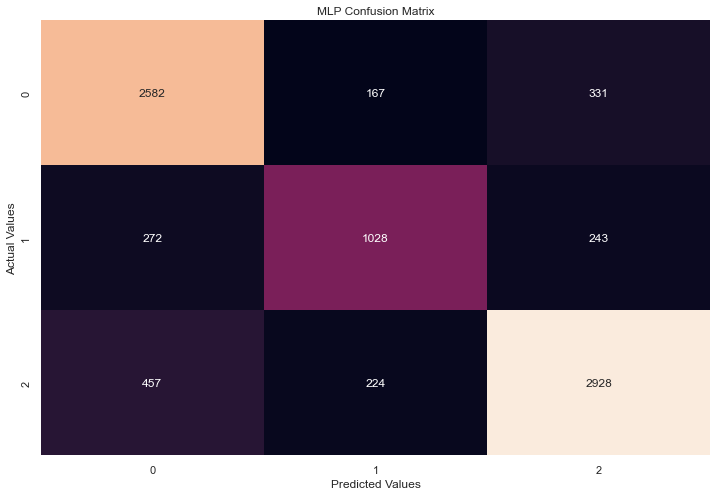

In [50]:
y_pred_mlp=mlp.predict(X_valid)
cm_mlp = confusion_matrix(y_valid, y_pred_mlp)
print('MLP Accuracy:', accuracy_score(y_valid, y_pred_mlp))
print(classification_report(y_valid, y_pred_mlp))
sns.heatmap(cm_mlp, annot=True, fmt='g', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('MLP Confusion Matrix')
plt.show()

#### Vectorizing with Word2Vec

In [51]:
import gensim
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("custom_embeddings.txt", binary=False)

In [52]:

X_train = train["Tweet"]
y_train = train["Sentiment"]
X_test = test["Tweet"]
y_test = test["Sentiment"]

model1_words = set(model.index_to_key)
X_train_vect = np.array([np.array([model[i] for i in ls if i in model1_words])
                         for ls in X_train])
X_test_vect = np.array([np.array([model[i] for i in ls if i in model1_words])
                         for ls in X_test])

X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(200, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(200, dtype=float))
X_train_vect_avg = np.array(X_train_vect_avg)
X_test_vect_avg = np.array(X_test_vect_avg)
print(X_train_vect_avg.shape)
print(X_test_vect_avg.shape)

(32925, 200)
(8232, 200)


In [53]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train_vect_avg, y_train)

logreg_prediction = logreg.predict(X_test_vect_avg)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train_vect_avg,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

Training accuracy Score    :  0.46882308276385726
Validation accuracy Score :  0.4716958211856171
              precision    recall  f1-score   support

           0       0.31      0.46      0.37      2091
           1       0.12      0.50      0.19       356
           2       0.76      0.48      0.59      5785

    accuracy                           0.47      8232
   macro avg       0.40      0.48      0.38      8232
weighted avg       0.62      0.47      0.51      8232

